# [Exploratory Data Analysis] Quotebank: A Corpus of Quotations from a Decade of News

The main dataset of our project is Quotebank and in this notebook we will conduct a data analysis. The Quotebank dataset contains quotes from various news sources. Using modern nerual methods Vaucher Timoté, et al. extracted valuable quotes and assigned possible speakers. The dataset contains more 178 million unique collected quotes between August 2008 and April 2020 from articles in the Spinn3r dataset. Quotes unlike articles can convey the emotions of the speaker which is why this dataset represents an immense amount of information on which many compelling questions can be asked and analysed. Our research will be in the direction of natural disasters. 

## Dataset loading

In [110]:
import os
import datetime
import json
import csv
import tld
import re
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar
import pycountry_convert
import plotly.express as px

In [51]:
from dask.distributed import Client
import dask.bag as db
import dask.dataframe as dd

client = Client("tcp://127.0.0.1:8786")
client

<Client: 'tcp://100.77.96.239:8786' processes=20 threads=20, memory=167.64 GiB>

In [75]:
# load parquet files from dataset and concat the years in one big dataset
DATASET_FAST_PATH = "datasets/quotebank"

quotebank_df_array = [dd.read_parquet(f"{DATASET_FAST_PATH}/quotes-{year}.parquet") for year in range(2008, 2021)]

dataset = dd.concat(quotebank_df_array, interleave_partitions=True)

In [76]:
# Convert date column to datetime objects
dataset["date"] = dd.to_datetime(dataset["date"])

In [55]:
# Print the dataset
dataset.head(10)

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,phase,speaker_prob,url_countries
0,2008-10-08-000029,10s of thousands of churches every week in the us,john mccain,Q10390,2008-10-08 14:12:13,1,[http://thenation.com/blogs/campaignmatters/36...,A,0.2767,[US]
1,2008-09-15-000037,"13th watered heavily up to the ridge, then roc...",gerry byrne,Multiple,2008-09-15 16:29:27,1,[http://belfasttelegraph.co.uk/sport/golf/amer...,A,0.4065,[UK]
2,2008-12-12-000046,"2 days in the valley,",None,None,2008-12-12 21:06:16,193,[http://netflixcinemajig.wordpress.com/2008/12...,A,0.2799,"[CA, IN, US, NZ, MY]"
3,2008-09-16-000159,80 per cent towards the basis of an agreement.,mario cossio,Q9029123,2008-09-16 01:12:16,2,[http://channelnewsasia.com/stories/afp_world/...,A,0.4073,[US]
4,2008-09-03-000269,"a challenge for the u.s. and the world,",None,None,2008-09-03 19:10:55,2,[http://warisboring.com/?p=1339],A,0.5239,[US]
5,2008-09-22-000262,a child's head is the heaviest part of his bod...,michael turner,Multiple,2008-09-22 14:01:20,1,[http://cnn.com/2008/HEALTH/family/09/22/accid...,A,0.5583,[US]
6,2008-11-18-000241,a common sense of reform being needed,john mccain,Q10390,2008-11-18 04:21:33,3,[http://politico.com/news/stories/1108/15718.h...,A,0.4711,[US]
7,2008-12-18-000256,a company-maker for centrex metals,None,None,2008-12-18 02:32:04,2,[http://news.theage.com.au/business/wuhan-to-i...,A,0.5135,[AS]
8,2008-09-25-000330,a core taking over our education system?,thomas muthee,Q7792644,2008-09-25 20:39:19,1,[http://woai.com/content/blogs/wiccan/story.as...,A,0.5289,[US]
9,2008-10-26-000173,a democracy cannot exist as a permanent form o...,benjamin franklin,Q52457636,2008-10-26 04:04:53,2,[http://blog.myspace.com/index.cfm?fuseaction=...,A,0.4495,[US]


## Missing values

Most real-world data is incomplete, with values missing due to various reasons. To understand how missing values affect quotebank, we will count how many missing values exist per column and display some rows with `NaN`.

In [7]:
n = len(dataset)
print(f"Number of quotes: {n}")

nans_per_column = dataset.isna().sum(axis=0).compute()

print(f"\n\nNaN's per column:")
print(nans_per_column)

print(f"\n\nNaN's per column (percentage):")
print(nans_per_column / n)

Number of quotes: 234994989


NaN's per column:
quoteID                  0
quotation                0
speaker                  0
qids              56486831
date                     0
numOccurrences           0
urls                     0
phase                    0
speaker_prob             0
url_countries      1954158
dtype: int64


NaN's per column (percentage):
quoteID           0.000000
quotation         0.000000
speaker           0.000000
qids              0.240375
date              0.000000
numOccurrences    0.000000
urls              0.000000
phase             0.000000
speaker_prob      0.000000
url_countries     0.008316
dtype: float64


In [8]:
dataset[dataset.isna().any(axis=1)].head()

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,phase,speaker_prob,url_countries
2,2008-12-12-000046,"2 days in the valley,",None,None,2008-12-12 21:06:16,193,[http://netflixcinemajig.wordpress.com/2008/12...,A,0.2799,"[CA, IN, US, NZ, MY]"
4,2008-09-03-000269,"a challenge for the u.s. and the world,",None,None,2008-09-03 19:10:55,2,[http://warisboring.com/?p=1339],A,0.5239,[US]
7,2008-12-18-000256,a company-maker for centrex metals,None,None,2008-12-18 02:32:04,2,[http://news.theage.com.au/business/wuhan-to-i...,A,0.5135,[AS]
13,2008-12-17-000431,a fitting reply to those political parties whi...,narendra modi,Q1058,2008-12-17 16:41:07,1,[http://newshopper.sulekha.com/newsitem/2008/1...,A,0.5986,None
19,2008-09-22-000734,a man who has killed the brother of another ne...,None,None,2008-09-22 10:20:48,3,[http://topnews.in/taliban-can-never-be-beaten...,A,0.5190,"[US, IN]"


The only missing values exist for `qids` and `url_countries`. Values in `qids` can be missing if the author couldn't be attributed and `url_countries` are missing if the domain of the newsportal's url could not be linked to a country in the domains dataset we used. Nothing fishy here.

### Phases

Because we want to do quote text analysis, we need to somehow fix the errors in encoding the text that occurred at different time periods. For simplicity, all question marks and other characters that are not part of the English alphabet will be removed from quotes. We will also remove possible url links and numbers from quotes unless there is a possibility that they represent a year. The numbers that represent the year are important to us because they may convey information when an accident occurred that can help us when searching for quotes that mention natural disasters. 

### Newsportal country distribution

Different news sources focus on different aspects of society and everyday life, also the geographical location of the source alone may affect what the articles will be about. Therefore, we will conduct an analysis of URL links to find out the origin of the news source, which could help us later. As the TLD domain itself does not contain completely correct information about the source of the information, we will use an part from the well-known GDELT project database. https://blog.gdeltproject.org/mapping-the-media-a-geographic-lookup-of-gdelts-sources/

In [106]:
counts = dataset.url_countries.dropna().astype("string").value_counts(sort=False)

countries_quote_count = {}

for countries, count in counts.iteritems():
    # convert string array to the array
    countries_list = countries[1:-1].replace("'", "").replace("\n", "").split(' ')
    for country in countries_list:
        # count the quotes per country
        countries_quote_count[country] = countries_quote_count.get(country, 0) + count

In [107]:
fips_country_name_lookup = {}
with open("datasets/gdelt_domain_by_country/FIPS.country.txt") as fips_file:
    for line in fips_file:
        fips_code, country_name = line.replace("\n", "").split("\t")
        fips_country_name_lookup[fips_code] = country_name

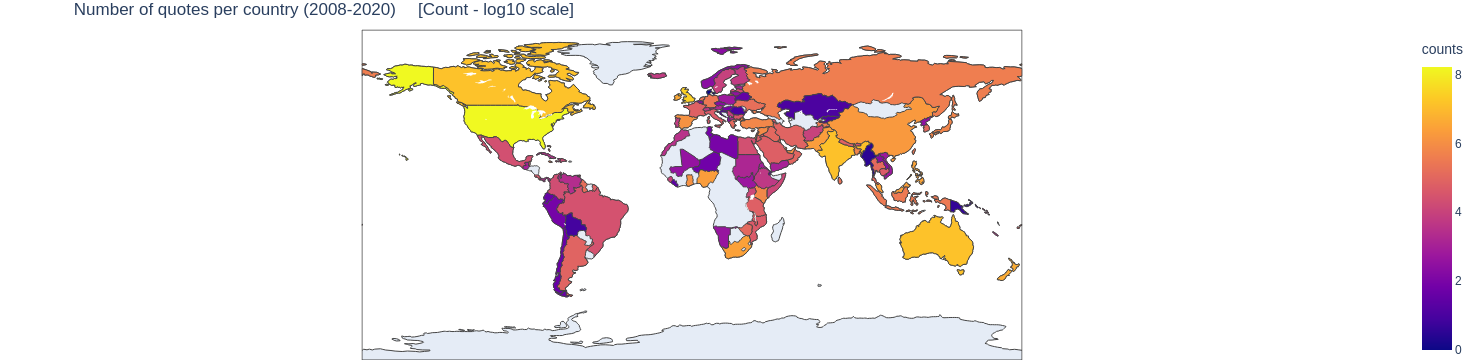

In [115]:
# reshape countries quote data to plot on map

df_countries_quote = pd.DataFrame.from_dict(countries_quote_count, orient='index')
df_countries_quote.reset_index(inplace=True)
df_countries_quote = df_countries_quote.rename(columns = {'index':'iso-code', 0:"counts"})
df_countries_quote["country_name"] =  df_countries_quote['iso-code'].apply(lambda c_code: fips_country_name_lookup[c_code])
# Kosovo has no label in ISO alpha 3 standard, so we manually label set it as ISO alpha 3 N/A
df_countries_quote['iso-code'] = df_countries_quote['iso-code'].apply(lambda c_code: pycountry_convert.country_name_to_country_alpha3(fips_country_name_lookup[c_code]) if c_code != "KV" else "XK")
df_countries_quote["counts"] = np.log10(df_countries_quote["counts"])


fig = px.choropleth(df_countries_quote, locations="iso-code",
                    color="counts", 
                    hover_name = df_countries_quote["country_name"],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = 'Number of quotes per country (2008-2020) \t [Count - log10 scale]')

fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

<img src="./images/number_of_quotes_per_country.jpeg" title="Number of quotes per country (2008-2020)" />

We can see that most quotes come from American news sources, but it is interesting to note a significant number of quotes from Canada, India and Australia. We did not expect this realization, but it will help us to investigate in more detail the connection between citations and natural disasters from the perspective of different countries. 

# Number of distinct quotes per day
In the search for further interesting patterns, let us first inspect the number of quotes per day. We will only count the distinct quotes and will not incorporate how many times a given quote occurred.

## Number of quotes through time

In [21]:
#convert date to coresponding day, month, year
dataset["date_day"] = dataset.date.dt.round("D")
dataset["date_week"] = dataset.date.dt.round("7D")
dataset["date_month"] = dataset.date.values.astype('datetime64[M]')
dataset["date_year"] = dataset.date.values.astype('datetime64[Y]')

In [ ]:
n_quotes_per_year = dataset.groupby("date_year").size().compute()
total_n_quotes = sum(n_quotes_per_year)
print(f"Number of quotes per year: {n_quotes_per_year}\n"
      f"Total number of quotes: {total_n_quotes}")

Number of quotes per year: date_year
2008-01-01     4641330
2009-01-01    19567082
2010-01-01    17208434
2011-01-01    19632724
2012-01-01    19849872
2013-01-01    18614447
2014-01-01    19896843
2015-01-01    20874338
2016-01-01    13862129
2017-01-01    26611588
2018-01-01    27228451
2019-01-01    21763302
2020-01-01     5244449
dtype: int64
Total number of quotes: 234994989


We can see that lower number of quotes during the year 2008 and 2020, which may have arisen because they have not been included in the dataset for a whole year.

In [23]:
ds_by_week = dataset.groupby("date_week")
number_of_quotes_per_week = ds_by_week.size().compute()

In [27]:
# Prepare date bins
infimum_date = datetime.date(2008, 9, 1)
supremum_date = datetime.date(2020, 4, 17)
print(f"Infimum date: {infimum_date}")
print(f"Supremum date: {supremum_date}")

Infimum date: 2008-09-01
Supremum date: 2020-04-17


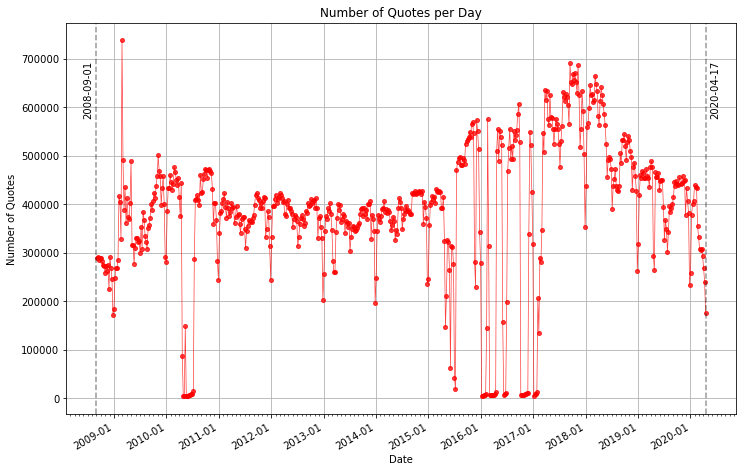

In [28]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.set_title("Number of Quotes per Day")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Quotes")

# Major ticks every week.
fmt_year = mdates.YearLocator()
ax.xaxis.set_major_locator(fmt_year)

# Minor ticks every day.
fmt_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Round to nearest months.
ax.grid(True)
ax.plot(number_of_quotes_per_week, c="r", linewidth=0.7, alpha=0.75, marker="o", linestyle="-", markersize=4)

v1 = plt.axvline(x=infimum_date, color='k', linestyle='--', alpha=0.4)
v2 = plt.axvline(x=supremum_date, color='k', linestyle='--', alpha=0.4)
plt.text(infimum_date - datetime.timedelta(90), plt.ylim()[1]*0.75, infimum_date, rotation=90)
plt.text(supremum_date + datetime.timedelta(30), plt.ylim()[1]*0.75, supremum_date, rotation=90)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()
plt.show()

We can observe that there are weeks when we have a small number of citations, we can see this observation in the original article of Quotebank, and such an anomaly arose due to the server crash. 

Looks good! Let's dive a bit closer and look into a full year. What about 2019?

In [31]:
dataset_2019 = dd.read_parquet(f"{DATASET_PATH}/quotes-{2019}.parquet")

dataset_2019["date"] = dd.to_datetime(dataset_2019["date"])
dataset_2019["date_day"] = dataset_2019.date.dt.round("D")

number_of_quotes_per_day_2019 = dataset_2019.groupby("date_day").size().compute()

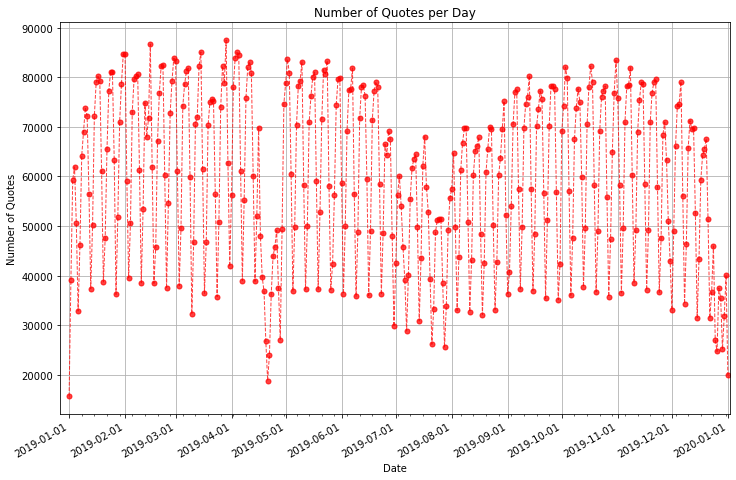

In [79]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.set_title("Number of Quotes per Day")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Quotes")

# Major ticks every month.
fmt_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_month )

# Minor ticks every week.
fmt_week = mdates.WeekdayLocator(interval=1)
ax.xaxis.set_minor_locator(fmt_week )

# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Round to nearest months.
datemin = np.datetime64(number_of_quotes_per_day_2019.index[0], "W")
datemax = np.datetime64(number_of_quotes_per_day_2019.index[-1], "W") + np.timedelta64(1, "W")
ax.set_xlim(datemin, datemax)
ax.grid(True)
ax.plot(number_of_quotes_per_day_2019, c="r", linewidth=1, alpha=0.75, marker="o", linestyle="--", markersize=5)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

Why is there a sharp decrease in the middle of each week. Is it because of the weekdays/weekends?

In [33]:
dataset["day_of_week"] = dataset["date"].dt.day_name()
ds_by_weekdays = dataset.groupby(dataset["day_of_week"])
number_of_quotes_per_weekday = ds_by_weekdays.size().compute()

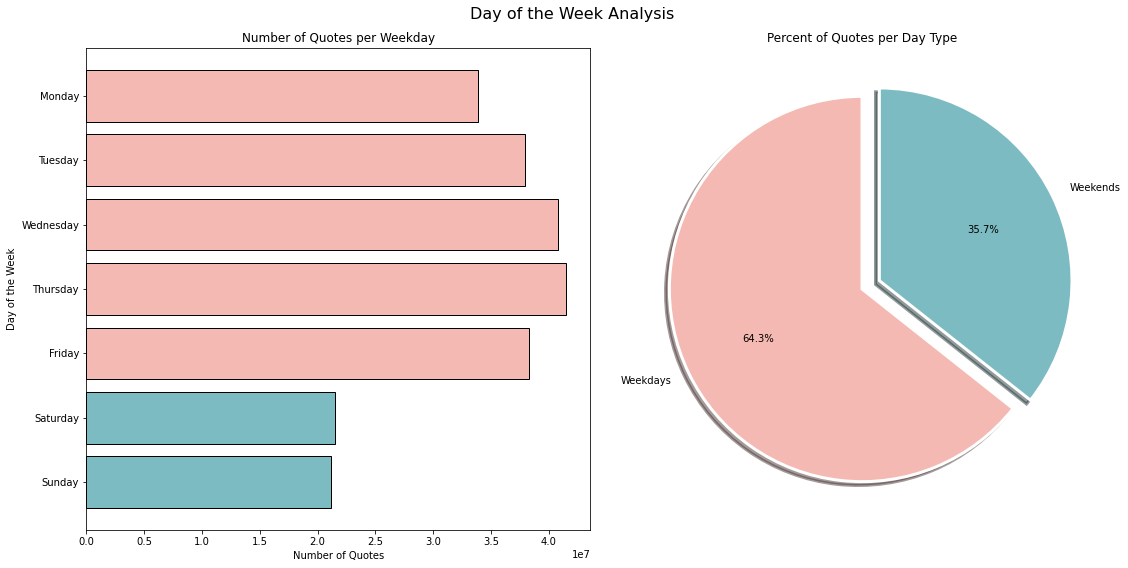

In [34]:
# Sort the index by the day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_type = (days_of_week[:5], days_of_week[5:])

mapping = {day: i for i, day in enumerate(reversed(days_of_week))}
key = number_of_quotes_per_weekday.index.map(mapping)
number_of_quotes_per_weekday = number_of_quotes_per_weekday.iloc[key.argsort()]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title("Number of Quotes per Weekday", fontsize=12)
ax[0].set_xlabel("Number of Quotes")
ax[0].set_ylabel("Day of the Week")
ax[1].set_title("Percent of Quotes per Day Type", fontsize=12)
fig.suptitle("Day of the Week Analysis", fontsize=16)

colors = ["#7DBBC3", "#7DBBC3", "#F4B9B2", "#F4B9B2", "#F4B9B2", "#F4B9B2", "#F4B9B2"]
ax[0].barh(number_of_quotes_per_weekday.index, number_of_quotes_per_weekday, edgecolor="black", color=colors)

ax[1].pie([number_of_quotes_per_weekday.loc[x].mean() for x in day_type], labels=["Weekdays", "Weekends"], autopct='%.1f%%', shadow=True, startangle=90, colors=["#F4B9B2", "#7DBBC3"], wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, explode=(0, 0.1))
plt.tight_layout()

Aha, we were right! Apparently many people decide to stay silent during the weekend.

Let's explore the trends

In [35]:
quote_trends_daily = pd.DataFrame({"n_quotes": number_of_quotes_per_day_2019}, index=number_of_quotes_per_day_2019.index)
quote_trends_7 = quote_trends_daily["n_quotes"].rolling(window=7, center=True, min_periods=5).mean()
quote_trends_30 = quote_trends_daily["n_quotes"].rolling(window=30, center=True, min_periods=20).mean()

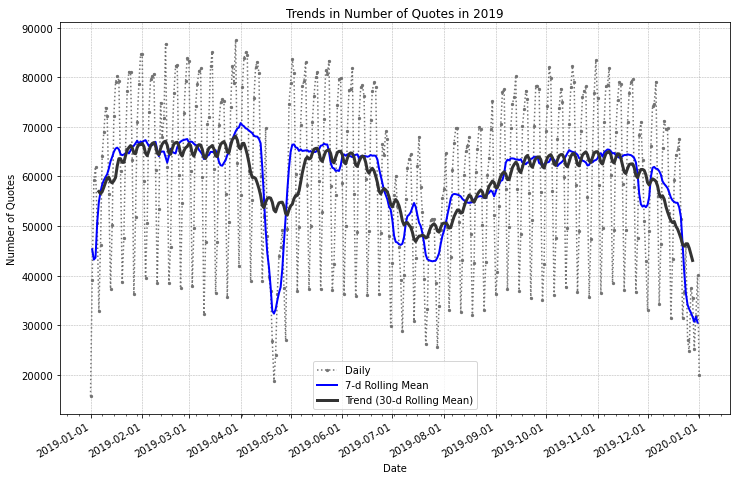

In [80]:
# Plot daily, 7-day rolling mean, and 30-day rolling mean
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(number_of_quotes_per_day_2019, marker=".", markersize=4.5, color="0.45", linestyle="dotted", label="Daily")
ax.plot(quote_trends_7, linewidth=2, label='7-d Rolling Mean', color="b")
ax.plot(quote_trends_30, color="0.2", linewidth=3, label="Trend (30-d Rolling Mean)")

# Major ticks every month.
fmt_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_month)

# Minor ticks every week.
fmt_week = mdates.WeekdayLocator(interval=1)
ax.xaxis.set_minor_locator(fmt_week)

# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax.legend()
ax.grid(True, linewidth=0.5, linestyle="--")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Quotes")
ax.set_title("Trends in Number of Quotes in 2019")

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()
plt.show()

## Number of quote occurrences

The number of citations can tell us how popular a quote is, so we will analyze the occurrence of individual quotes in the Quotebank database. 

In [56]:
num_occurrences = dataset["numOccurrences"].astype(np.int64)

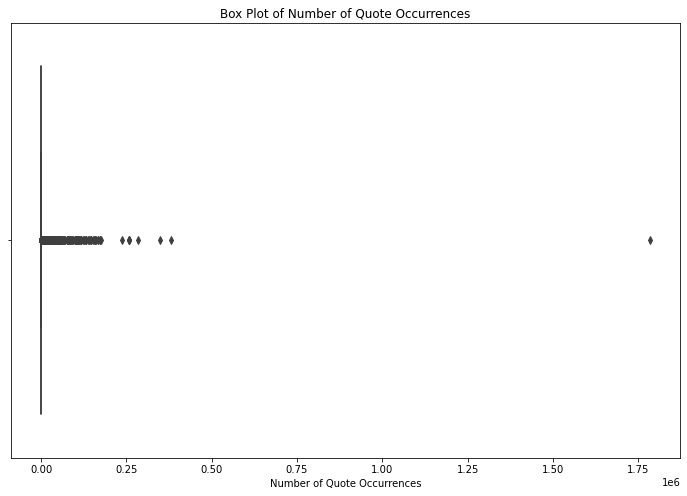

In [62]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(x=num_occurrences.compute(), ax=ax)
ax.set_xlabel("Number of Quote Occurrences")
ax.set_title("Box Plot of Number of Quote Occurrences")
plt.show()

Woah! So many outliers...

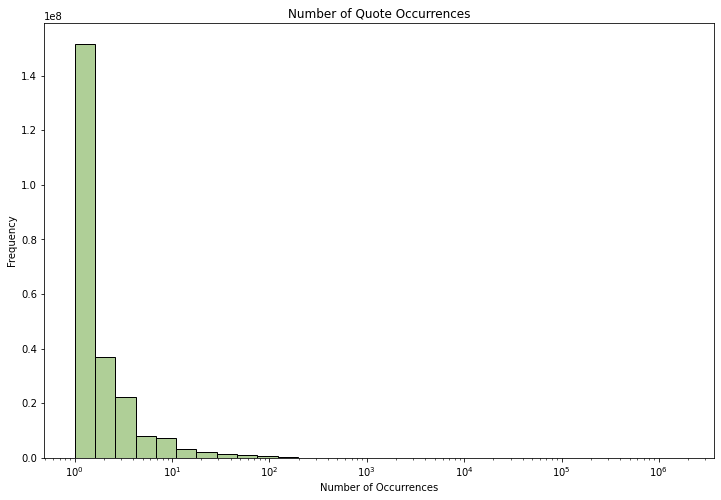

In [88]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.histplot(num_occurrences.compute(), ax=ax, log_scale=True, bins=30, color="#95BF74")

ax.set_title("Number of Quote Occurrences")
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of Occurrences")

plt.show()

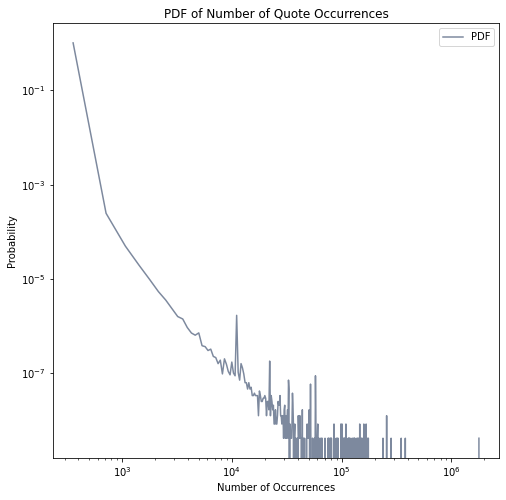

In [57]:
# Plot the PDF of number of occurrences
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set(xscale="log", yscale="log")

count, bins_count = np.histogram(num_occurrences, bins=5000)
pdf = count / sum(count)

ax.set_title("PDF of Number of Quote Occurrences")
ax.set_ylabel("Probability")
ax.set_xlabel("Number of Occurrences")

# plotting PDF and CDF
ax.plot(bins_count[1:], pdf, color="#465775", label="PDF", alpha=0.7)
ax.legend()
plt.show()

We see that there are a few quotes that have a lot of impressions, this may be because they are very popular. 

## Speaker probabilities


In [77]:
speaker_prob = dataset["speaker_prob"].astype(np.float64)

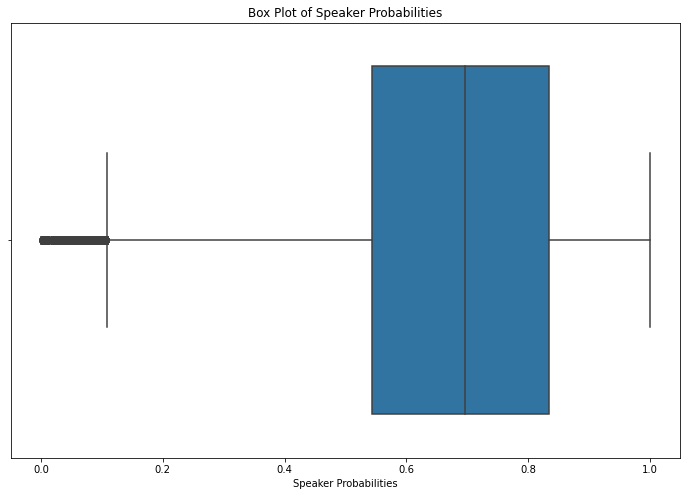

In [81]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(x=speaker_prob.compute(), ax=ax)
ax.set_xlabel("Speaker Probabilities")
ax.set_title("Box Plot of Speaker Probabilities")
plt.show()

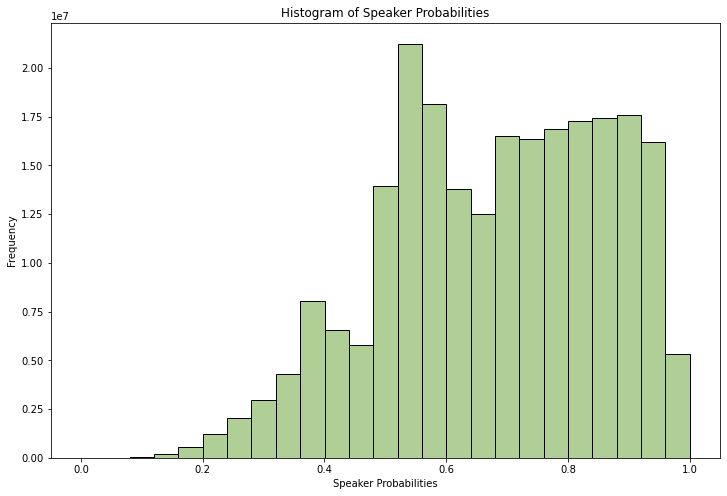

In [78]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.histplot(speaker_prob.compute(), bins=25, color="#95BF74")

ax.set_title("Histogram of Speaker Probabilities")
ax.set_ylabel("Frequency")
ax.set_xlabel("Speaker Probabilities")

plt.show()

## Lenght of the quote


In [83]:
# Get the number of words per quote
dataset["n_word"] = dataset.apply(lambda x: len(re.compile(r'\w+').findall(x["quotation"])), axis=1, meta="np.int64")

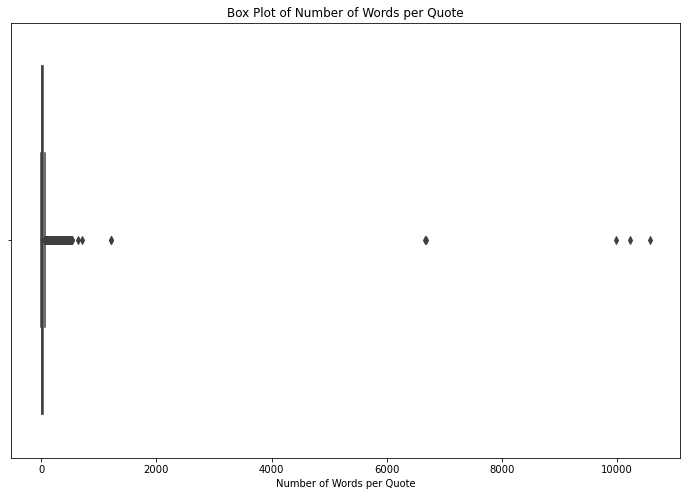

In [84]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(x=dataset["n_word"].compute(), ax=ax)
ax.set_xlabel("Number of Words per Quote")
ax.set_title("Box Plot of Number of Words per Quote")
plt.show()

In [ ]:
dataset_n_word = dataset["n_word"].compute()

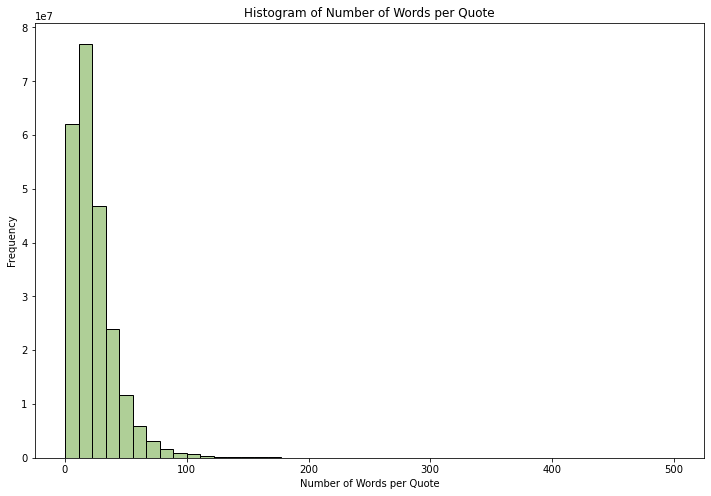

In [105]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.histplot(dataset_n_word[dataset_n_word.between(0, 500)], bins=45, color="#95BF74")

ax.set_title("Histogram of Number of Words per Quote")
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of Words per Quote")

plt.show()

## Haiti earthquake case-study

The method we propose to find whether a quote is about a certain disaster is to do simple text searching to match the expected words. To get a feeling about how we would do it and about its feasibility, we give a short case study of searching for quotes about the disaster with the biggest number of daeths -- the Haiti earthquake in 2010.

We will explore what results we get in three scenarios. In the respective scenario we will require the quote to contain the following words:
1. `haiti`, `earthquake`
2. `haiti`, `earthquake`, `2010`
3. `earthquake`, `2010`

In [63]:
# Test the regex is working first
def contain_all_words_regex(words):
    return "".join([f"(?=.*{word})" for word in words])

regex = contain_all_words_regex(["haiti", "earthquake"])

candidates = pd.Series([
    "haiti",
    "earthquake",
    "haitiearthquake",
    "haiti earthquake",
    "....haiti___earthquake",
    "earthquake haiti",
    "haiti earthquake haiti haiti haiti",
    "hait earthquak",
    "aiti arthquake",
    "HAITI...Earthquake",
    "this is ma string",
    "rindfleischetikettierungsüberwachungsaufgabenübertragungsgesetz",
])
expected_regex_match = pd.Series([
    False, False, True, True, True, True, True, False, False, True, False, False
])

regex_match = candidates.str.lower().str.contains(regex, regex=True)
assert((regex_match == expected_regex_match).all())
for i in range(len(candidates)):
    print(f"{regex_match.iloc[i]} <-- {candidates.iloc[i]}")

False <-- haiti
False <-- earthquake
True <-- haitiearthquake
True <-- haiti earthquake
True <-- ....haiti___earthquake
True <-- earthquake haiti
True <-- haiti earthquake haiti haiti haiti
False <-- hait earthquak
False <-- aiti arthquake
True <-- HAITI...Earthquake
False <-- this is ma string
False <-- rindfleischetikettierungsüberwachungsaufgabenübertragungsgesetz


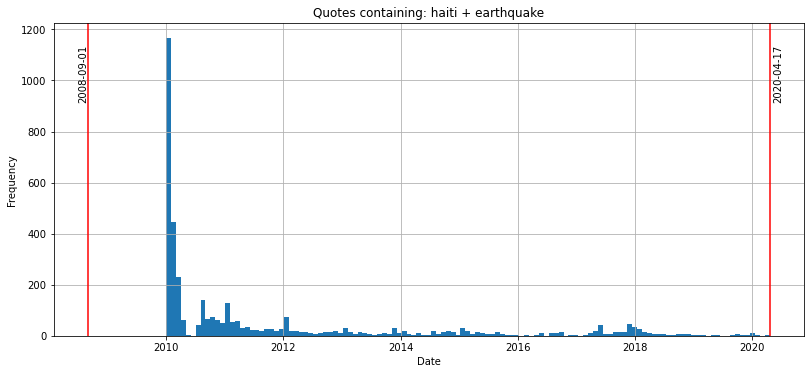

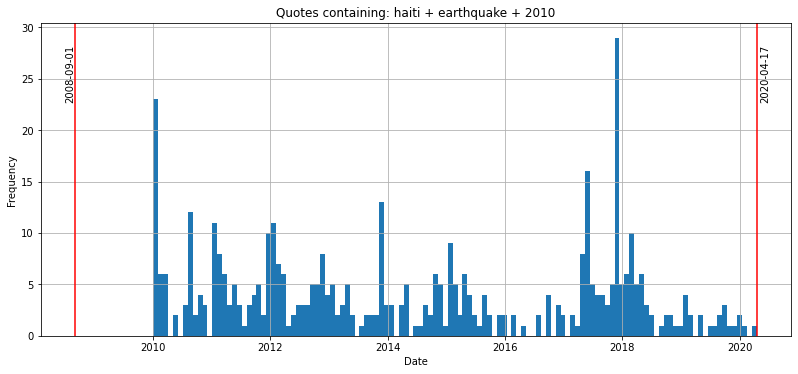

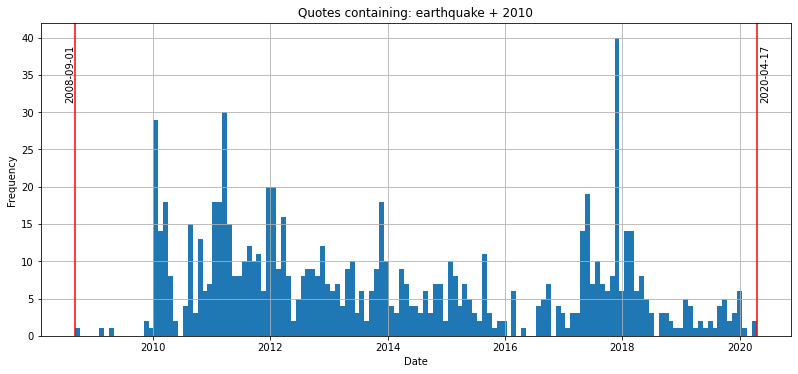

In [71]:
# The three scenarios
def quotes_that_contain_all_words(words):
    return dataset[dataset.quotation.str.lower().str.contains(contain_all_words_regex(words), regex=True)]

bins = np.linspace(calendar.timegm(infimum_date.timetuple()), calendar.timegm(supremum_date.timetuple()), 140)
bins = [datetime.date.fromtimestamp(timestamp) for timestamp in bins]

for scenario_words in [["haiti", "earthquake"], ["haiti", "earthquake", "2010"], ["earthquake", "2010"]]:
    dates = quotes_that_contain_all_words(scenario_words).date.compute()
    dates.hist(bins=bins, figsize=(6.4*2.1,4.8*1.2))

    plt.title(f"Quotes containing: {' + '.join(scenario_words)}")
    plt.xlabel("Date")
    plt.ylabel("Frequency")

    v1 = plt.axvline(x=infimum_date, color='r', linestyle='-')
    v2 = plt.axvline(x=supremum_date, color='r', linestyle='-')
    plt.text(infimum_date - datetime.timedelta(60), plt.ylim()[1]*0.75, infimum_date, rotation=90)
    plt.text(supremum_date + datetime.timedelta(20), plt.ylim()[1]*0.75, supremum_date, rotation=90)

    plt.show()

In the first two graphs we can see a clear boundary in 2010 when the earthquake occurred in Haiti. This could mean that these are quotes related to the earthquake. We also see a large amount of quotes after the earthquake which could suggest that people are talking about the earthquake. In the third graph we can observe several quotations that occurred before the observed earthquake and they certainly do not relate to our observation. Overall, we can conclude that the quote search method in which we search the names of otherwise lesser known places might be sufficient to find quotes related to the accident. And we will study this in the next part of the project. 